In [2]:
# this notebook needs to be run in a pymc3 environment.  

# BML Semester Project

Alice Wright - aew7j

Meredith Bunch - mlb2et

Edward Thompson - ejt8b

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')
sns.set_style('white')

import pymc3 as pm

# current_palette = sns.color_palette()
# sns.palplot(current_palette)
# plt.figure(figsize=(20,12))
# sns.palplot(sns.color_palette("bright", 10))
# plt.show()

In [4]:
# instal excel reader
# !pip install openpyxl

In [5]:
df = pd.read_excel('CFD_NFIRS_1_1_17to_6_25_21.xlsx')

In [6]:
df

Incident Number Incident Date  Basic Incident Hour Of Day 24  \
0        2016-00006845    2017-01-01                             20   
1        2016-00006845    2017-01-01                             20   
2        2016-00006845    2017-01-01                             20   
3        2016-00006845    2017-01-01                             20   
4        2017-00000006    2017-01-01                              1   
...                ...           ...                            ...   
107723   2021-00005152    2021-06-25                             19   
107724   2021-00005155    2021-06-25                             20   
107725   2021-00005155    2021-06-25                             20   
107726   2021-00005155    2021-06-25                             20   
107727   2021-00005155    2021-06-25                             20   

                            Incident Primary Action Taken  \
0                                        Provide manpower   
1                                        Provide manpower   
2                                        Provide manpower   
3                                        Provide manpower   
4       Hazardous materials spill control and confinement   
...                                                   ...   
107723                                        Investigate   
107724                                        Investigate   
107725                                        Investigate   
107726                                        Investigate   
107727                                        Investigate   

       Apparatus Resource Actions Taken Code And Description 1  \
0                                                     NaN        
1                                                     NaN        
2                                                     NaN        
3                                                     NaN        
4                                                     NaN        
...                                                   ...        
107723                                                NaN        
107724                                                NaN        
107725                                                NaN        
107726                                                NaN        
107727                                                NaN        

       Apparatus Resource Arrival Date Time  \
0                       2016-12-31 20:14:27   
1                       2016-12-31 20:14:27   
2                       2016-12-31 20:14:27   
3                       2016-12-31 20:17:22   
4                       2017-01-01 01:50:46   
...                                     ...   
107723                  2021-06-25 19:27:28   
107724                  2021-06-25 20:45:34   
107725                  2021-06-25 20:45:34   
107726                  2021-06-25 20:45:34   
107727                  2021-06-25 20:47:25   

        Apparatus Resource Arrival Sequence Number By Overall Incident  \
0                                                       1                
1                                                       1                
2                                                       1                
3                                                       2                
4                                                       1                
...                                                   ...                
107723                                                  2                
107724                                                  1                
107725                                                  1                
107726                                                  1                
107727                                                  2                

        Apparatus Resource On Scene Time in Minutes  \
0                                               NaN   
1                                               NaN   
2        

## Quick peek at the data

In [7]:
df.columns

Index(['Incident Number', 'Incident Date', 'Basic Incident Hour Of Day 24',
       'Incident Primary Action Taken',
       'Apparatus Resource Actions Taken Code And Description 1',
       'Apparatus Resource Arrival Date Time',
       'Apparatus Resource Arrival Sequence Number By Overall Incident',
       'Apparatus Resource On Scene Time in Minutes',
       'Apparatus Resource Arrived To In Service In Minutes',
       'Apparatus Resource Dispatch Date Time',
       'Incident Alarm Handling Time In Minutes',
       'Apparatus Resource Turnout Time In Minutes',
       'Apparatus Resource En Route To Arrived In Minutes',
       'Total Response Time', 'Apparatus Resource En Route Date Time',
       'Apparatus Resource ID',
       'Apparatus Resource Primary Action Taken Code And Description',
       'Apparatus Resource Type',
       'Incident First Unit Arrived Apparatus Resource ID',
       'Apparatus Personnel Full Name', 'Apparatus Personnel Role',
       'Apparatus Resource Actions 

In [8]:
df[['Basic Incident Type Category', 'Basic Incident Type Code And Description']]

Basic Incident Type Category  \
0       3 - Rescue & Emergency Medical Service Incident   
1       3 - Rescue & Emergency Medical Service Incident   
2       3 - Rescue & Emergency Medical Service Incident   
3       3 - Rescue & Emergency Medical Service Incident   
4       3 - Rescue & Emergency Medical Service Incident   
...                                                 ...   
107723                             6 - Good Intent Call   
107724                     7 - False Alarm & False Call   
107725                     7 - False Alarm & False Call   
107726                     7 - False Alarm & False Call   
107727                     7 - False Alarm & False Call   

                 Basic Incident Type Code And Description  
0       321 - EMS call, excluding vehicle accident wit...  
1       321 - EMS call, excluding vehicle accident wit...  
2       321 - EMS call, excluding vehicle accident wit...  
3       321 - EMS call, excluding vehicle accident wit...  
4          324 - Motor vehicle accident with no injuries.  
...                                                   ...  
107723                   651 - Smoke scare, odor of smoke  
107724   740 - Unintentional transmission of alarm, other  
107725   740 - Unintentional transmission of alarm, other  
107726   740 - Unintentional transmission of alarm, other  
107727   740 - Unintentional transmission of alarm, other  

[107728 rows x 2 columns]

In [9]:
df[['Basic Incident Type Category']].value_counts()

Basic Incident Type Category                           
3 - Rescue & Emergency Medical Service Incident            60123
7 - False Alarm & False Call                               19060
6 - Good Intent Call                                        8700
4 - Hazardous Condition (No Fire)                           8350
1 - Fire                                                    6166
5 - Service Call                                            4950
2 - Overpressure Rupture, Explosion, Overheat (No Fire)      199
8 - Severe Weather & Natural Disaster                        104
9 - Special Incident Type                                     48
dtype: int64

In [10]:
df['Total Response Time'].describe()

count    107728.000000
mean          6.769267
std           2.591829
min           0.270000
25%           5.150000
50%           6.350000
75%           7.900000
max          36.260000
Name: Total Response Time, dtype: float64

Lets put the response time in Bins.  The goal of response time is under 4 mintues

In [11]:
df['trt_bin'] = pd.cut(df['Total Response Time'],
       bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 20, 30, 40], 
       labels = ['Under 2 Min', '2 to 4 Min', '4 to 6 Min', '6 to 8 Min',
                 '8 to 10 Min', '10 to 12 Min', '12 to 14 Min', '14 to 16 Min', 
                 '16 to 20 Min', '20 to 30 Min', '30 to 40 Min'])

In [12]:
df['trt_bin'].value_counts()

4 to 6 Min      37437
6 to 8 Min      35915
8 to 10 Min     16355
2 to 4 Min       8126
10 to 12 Min     5531
12 to 14 Min     1937
14 to 16 Min      787
Under 2 Min       698
16 to 20 Min      549
20 to 30 Min      361
30 to 40 Min       32
Name: trt_bin, dtype: int64

<AxesSubplot:xlabel='trt_bin', ylabel='Count'>

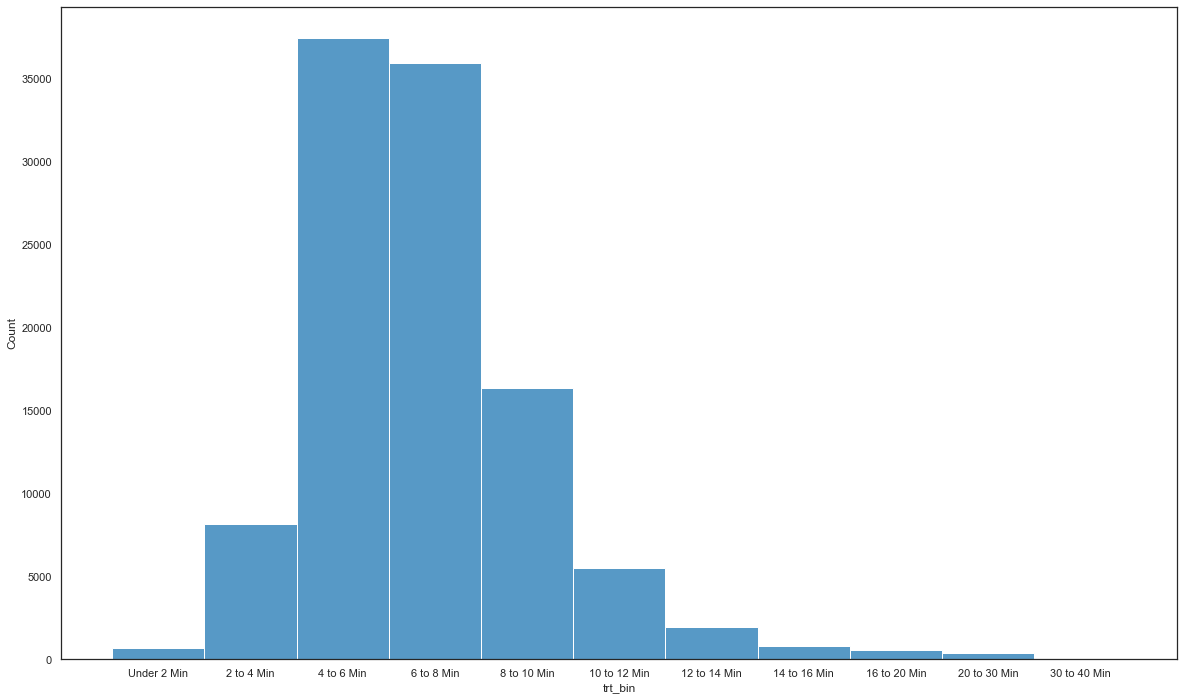

In [13]:
#plot histogram of the respone time bins
plt.figure(figsize=(20,12))
sns.histplot(data=df, x="trt_bin")

In [14]:
apparatus_usage = df['Apparatus Resource ID'].value_counts()
apparatus_usage

E7         19051
E5         16878
E1         12590
E10        11276
TRK9        8398
RSFM10      6244
TO10        5504
RSFM1       4762
TRK8        2414
RS140       2241
RS145       2086
RS146       1793
E2          1686
RS143       1530
BC1         1492
E4          1478
E3          1404
A01         1163
RS142        995
RS144        984
RS147        901
RS141        849
DUTY1        830
BC6          444
BC2          207
FM4           78
FM2           62
BC3           62
RES1          54
OPS2          53
FM3           37
SQ10          37
CHF1          33
HM01          22
SQ135         16
SQ133         15
FM1           12
Truck 9        9
SQ134          7
CHF3           7
ISU1           4
E111           4
GAT1           4
E82            3
UVA2           3
FM10           2
RSFM2          2
E83            1
FM6            1
Name: Apparatus Resource ID, dtype: int64

Lets look at only the most used apparatus

In [15]:
high_use_apparatus = apparatus_usage[apparatus_usage > 1000]
high_use_apparatus = high_use_apparatus.to_frame().reset_index()
high_use_apparatus.rename(columns = {'Apparatus Resource ID' : 'Apparatus Usage', 'index' : 'Apparatus Resource ID'}, inplace = True)
high_use_apparatus

Apparatus Resource ID  Apparatus Usage
0                     E7            19051
1                     E5            16878
2                     E1            12590
3                    E10            11276
4                   TRK9             8398
5                 RSFM10             6244
6                   TO10             5504
7                  RSFM1             4762
8                   TRK8             2414
9                  RS140             2241
10                 RS145             2086
11                 RS146             1793
12                    E2             1686
13                 RS143             1530
14                   BC1             1492
15                    E4             1478
16                    E3             1404
17                   A01             1163

<function matplotlib.pyplot.show(close=None, block=None)>

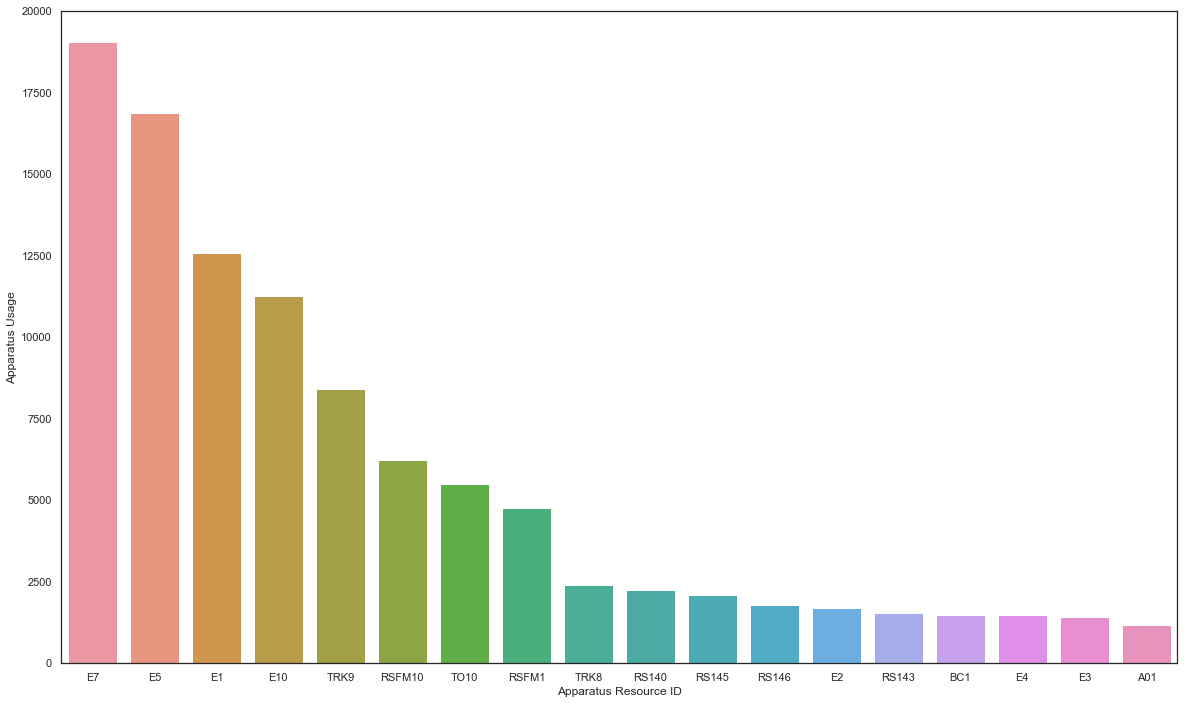

In [16]:
plt.figure(figsize=(20,12))
# sns.set(style="ticks")

sns.barplot(data = high_use_apparatus, x = 'Apparatus Resource ID', y = 'Apparatus Usage')

plt.show

In this data set the primary usage is from the four Engines of CFD as can be seen from this data, Engines are the primary vehicle of the department response.

![CFD Engine Response Districts](EngineZone.jpg)

A brief overview from https://firefighternow.com/fire-engine-vs-fire-truck/
Fire engines and fire trucks are different in the following ways:
* Fire engines usually get to the scene before fire trucks 
* Fire engines are used for putting out fires while fire trucks are for victim rescue, roof ventilation, and controlling the fire should it grow larger
* Fire engines include equipment like hoses, pumps and water tanks (which is why they’re sometimes called pumpers)
* Fire trucks have ventilation and rescue equipment and an assortment of hydraulic aerial ladders

An overview of apparatus costs

![Example Apparatus Costs](truck_cost.jpg)


For this project we will focus only on the CFD Engine Data

In [17]:
# The Engines are the top 4 resources in CFD
df['Apparatus Resource ID'].value_counts().head(4)

E7     19051
E5     16878
E1     12590
E10    11276
Name: Apparatus Resource ID, dtype: int64

In [18]:
# count our records
df['Apparatus Resource ID'].value_counts().head(4).sum()

59795

In [19]:
#check data type
df['Apparatus Resource ID'].dtype

dtype('O')

In [20]:
#flip it to string
df['Apparatus Resource ID'] = df['Apparatus Resource ID'].astype('string')

In [21]:
df['Apparatus Resource ID'].dtype

string[python]

In [22]:
# subset using ID.  I can't get it to subset using or statement |
df[df['Apparatus Resource ID'] == 'E7']

Incident Number Incident Date  Basic Incident Hour Of Day 24  \
8        2017-00000007    2017-01-01                              1   
9        2017-00000007    2017-01-01                              1   
10       2017-00000007    2017-01-01                              1   
29       2017-00000020    2017-01-01                             12   
30       2017-00000020    2017-01-01                             12   
...                ...           ...                            ...   
107719   2021-00005152    2021-06-25                             19   
107720   2021-00005152    2021-06-25                             19   
107724   2021-00005155    2021-06-25                             20   
107725   2021-00005155    2021-06-25                             20   
107726   2021-00005155    2021-06-25                             20   

       Incident Primary Action Taken  \
8                 Cancelled en route   
9                 Cancelled en route   
10                Cancelled en route   
29                    Forcible entry   
30                    Forcible entry   
...                              ...   
107719                   Investigate   
107720                   Investigate   
107724                   Investigate   
107725                   Investigate   
107726                   Investigate   

       Apparatus Resource Actions Taken Code And Description 1  \
8                                                     NaN        
9                                                     NaN        
10                                                    NaN        
29                                                    NaN        
30                                                    NaN        
...                                                   ...        
107719                                                NaN        
107720                                                NaN        
107724                                                NaN        
107725                                                NaN        
107726                                                NaN        

       Apparatus Resource Arrival Date Time  \
8                       2017-01-01 01:49:42   
9                       2017-01-01 01:49:42   
10                      2017-01-01 01:49:42   
29                      2017-01-01 12:32:06   
30                      2017-01-01 12:32:06   
...                                     ...   
107719                  2021-06-25 19:27:03   
107720                  2021-06-25 19:27:03   
107724                  2021-06-25 20:45:34   
107725                  2021-06-25 20:45:34   
107726                  2021-06-25 20:45:34   

        Apparatus Resource Arrival Sequence Number By Overall Incident  \
8                                                       2                
9                                                       2                
10                                                      2                
29                                                      1                
30                                                      1                
...                                                   ...                
107719                                                  1                
107720                                                  1                
107724                                                  1                
107725                                                  1                
107726                                                  1                

        Apparatus Resource On Scene Time in Minutes  \
8                                               NaN   
9                                               NaN   
10                                              NaN   
29                                              NaN   
30                                              NaN   
...                                             ...   
107719                                   

In [23]:
# write a list to make a loop for subsetting
e_list = ['E7', 'E5','E1', 'E10']
e_list

['E7', 'E5', 'E1', 'E10']

In [24]:
for e in e_list:
    print (e)

E7
E5
E1
E10


In [25]:
#set an empty df
df_engine = pd.DataFrame()


In [26]:
# index through list, subset on equipment id, join together in new df

for e in e_list:
           
    temp_df = df[df['Apparatus Resource ID'] == e]
    df_engine = df_engine.append(temp_df, ignore_index=True)

In [27]:
df_engine

Incident Number Incident Date  Basic Incident Hour Of Day 24  \
0       2017-00000007    2017-01-01                              1   
1       2017-00000007    2017-01-01                              1   
2       2017-00000007    2017-01-01                              1   
3       2017-00000020    2017-01-01                             12   
4       2017-00000020    2017-01-01                             12   
...               ...           ...                            ...   
59790   2021-00005109    2021-06-24                             12   
59791   2021-00005109    2021-06-24                             12   
59792   2021-00005120    2021-06-24                             18   
59793   2021-00005120    2021-06-24                             18   
59794   2021-00005120    2021-06-24                             18   

             Incident Primary Action Taken  \
0                       Cancelled en route   
1                       Cancelled en route   
2                       Cancelled en route   
3                           Forcible entry   
4                           Forcible entry   
...                                    ...   
59790                          Investigate   
59791                          Investigate   
59792  Provide advanced life support (ALS)   
59793  Provide advanced life support (ALS)   
59794  Provide advanced life support (ALS)   

      Apparatus Resource Actions Taken Code And Description 1  \
0                                                    NaN        
1                                                    NaN        
2                                                    NaN        
3                                                    NaN        
4                                                    NaN        
...                                                  ...        
59790                                                NaN        
59791                                                NaN        
59792                                                NaN        
59793                                                NaN        
59794                                                NaN        

      Apparatus Resource Arrival Date Time  \
0                      2017-01-01 01:49:42   
1                      2017-01-01 01:49:42   
2                      2017-01-01 01:49:42   
3                      2017-01-01 12:32:06   
4                      2017-01-01 12:32:06   
...                                    ...   
59790                  2021-06-24 12:29:30   
59791                  2021-06-24 12:29:30   
59792                  2021-06-24 18:31:14   
59793                  2021-06-24 18:31:14   
59794                  2021-06-24 18:31:14   

       Apparatus Resource Arrival Sequence Number By Overall Incident  \
0                                                      2                
1                                                      2                
2                                                      2                
3                                                      1                
4                                                      1                
...                                                  ...                
59790                                                  1                
59791                                                  1                
59792                                                  1                
59793                                                  1                
59794                                                  1                

       Apparatus Resource On Scene Time in Minutes  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   
...                                            ...   
59790                  

In [28]:
# set an index for each engine to be used later in model
def eng_index(x):
    if x == 'E7':
        return '0'
    elif x == 'E5':
        return '1'
    elif x == 'E1':
        return '2'
    elif x == 'E10':
        return '3'    
    return


In [29]:
df_engine['engine_index'] = df_engine['Apparatus Resource ID'].apply(eng_index)

In [30]:
# df['date2'] = pd.to_datetime(df['Incident Date'],format='%Y%m%d')
df_engine['year'] = pd.DatetimeIndex(df_engine['Incident Date']).year
df_engine['month'] = pd.DatetimeIndex(df_engine['Incident Date']).month

In [31]:
df_engine

Incident Number Incident Date  Basic Incident Hour Of Day 24  \
0       2017-00000007    2017-01-01                              1   
1       2017-00000007    2017-01-01                              1   
2       2017-00000007    2017-01-01                              1   
3       2017-00000020    2017-01-01                             12   
4       2017-00000020    2017-01-01                             12   
...               ...           ...                            ...   
59790   2021-00005109    2021-06-24                             12   
59791   2021-00005109    2021-06-24                             12   
59792   2021-00005120    2021-06-24                             18   
59793   2021-00005120    2021-06-24                             18   
59794   2021-00005120    2021-06-24                             18   

             Incident Primary Action Taken  \
0                       Cancelled en route   
1                       Cancelled en route   
2                       Cancelled en route   
3                           Forcible entry   
4                           Forcible entry   
...                                    ...   
59790                          Investigate   
59791                          Investigate   
59792  Provide advanced life support (ALS)   
59793  Provide advanced life support (ALS)   
59794  Provide advanced life support (ALS)   

      Apparatus Resource Actions Taken Code And Description 1  \
0                                                    NaN        
1                                                    NaN        
2                                                    NaN        
3                                                    NaN        
4                                                    NaN        
...                                                  ...        
59790                                                NaN        
59791                                                NaN        
59792                                                NaN        
59793                                                NaN        
59794                                                NaN        

      Apparatus Resource Arrival Date Time  \
0                      2017-01-01 01:49:42   
1                      2017-01-01 01:49:42   
2                      2017-01-01 01:49:42   
3                      2017-01-01 12:32:06   
4                      2017-01-01 12:32:06   
...                                    ...   
59790                  2021-06-24 12:29:30   
59791                  2021-06-24 12:29:30   
59792                  2021-06-24 18:31:14   
59793                  2021-06-24 18:31:14   
59794                  2021-06-24 18:31:14   

       Apparatus Resource Arrival Sequence Number By Overall Incident  \
0                                                      2                
1                                                      2                
2                                                      2                
3                                                      1                
4                                                      1                
...                                                  ...                
59790                                                  1                
59791                                                  1                
59792                                                  1                
59793                                                  1                
59794                                                  1                

       Apparatus Resource On Scene Time in Minutes  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   
...                                            ...   
59790                  

In [32]:
df_engine[['year', 'Incident Primary Action Taken']].value_counts(['year', 'Incident Primary Action Taken']).to_frame()

0
year Incident Primary Action Taken              
2019 Investigate                            6415
2018 Investigate                            5817
2020 Investigate                            5208
2017 Investigate                            4819
2020 Provide basic life support (BLS)       2578
...                                          ...
2019 Enforce codes                             3
2021 Enforce codes                             3
2020 Notify other agencies.                    3
2017 Identify, analyze hazardous materials     2
2019 Refer to proper authority                 2

[214 rows x 1 columns]

In [33]:
df_engine['Incident Primary Action Taken'].unique()

array(['Cancelled en route', 'Forcible entry',
       'Provide basic life support (BLS)', 'Provide manpower',
       'Provide first aid & check for injuries', 'Investigate',
       'Extinguishment by fire service personnel',
       'Provide advanced life support (ALS)',
       'Hazardous materials spill control and confinement', nan,
       'Information, investigation & enforcement, other',
       'Control traffic', 'Assistance, other',
       'Emergency medical services, other', 'Standby',
       'Establish safe area', 'Provide equipment',
       'Hazardous materials leak control & containment',
       'Fire control or extinguishment, other',
       'Investigate fire out on arrival', 'Assist physically disabled',
       'Systems and services, other', 'Remove hazard',
       'Salvage & overhaul', 'Action taken, other', 'Ventilate',
       'Secure property', 'Provide water', 'Rescue, remove from harm',
       'Transport person', 'Restore fire alarm system',
       'Shut down system', 'O

In [34]:
df_engine.groupby(['Incident Primary Action Taken']).size().sort_values(ascending = False)

Incident Primary Action Taken
Investigate                                           24590
Provide basic life support (BLS)                      10336
Provide manpower                                       5538
Provide advanced life support (ALS)                    4503
Standby                                                3544
Assistance, other                                      2252
Extinguishment by fire service personnel               1684
Cancelled en route                                      787
Emergency medical services, other                       658
Lifting Assistance                                      611
Forcible entry                                          530
Transport person                                        425
Ventilate                                               378
Provide first aid & check for injuries                  354
Assist physically disabled                              326
Fire control or extinguishment, other                   325
Establish 

Most of these look useful, but lets remove the records for "cancled in route" as the engine will have never arrived on scene

In [35]:
# Drop row on condition from https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression

df_engine = df_engine.drop(df_engine[df_engine['Incident Primary Action Taken'] == 'Cancelled en route'].index)
df_engine

Incident Number Incident Date  Basic Incident Hour Of Day 24  \
3       2017-00000020    2017-01-01                             12   
4       2017-00000020    2017-01-01                             12   
5       2017-00000020    2017-01-01                             12   
6       2017-00000021    2017-01-01                             13   
7       2017-00000021    2017-01-01                             13   
...               ...           ...                            ...   
59790   2021-00005109    2021-06-24                             12   
59791   2021-00005109    2021-06-24                             12   
59792   2021-00005120    2021-06-24                             18   
59793   2021-00005120    2021-06-24                             18   
59794   2021-00005120    2021-06-24                             18   

             Incident Primary Action Taken  \
3                           Forcible entry   
4                           Forcible entry   
5                           Forcible entry   
6         Provide basic life support (BLS)   
7         Provide basic life support (BLS)   
...                                    ...   
59790                          Investigate   
59791                          Investigate   
59792  Provide advanced life support (ALS)   
59793  Provide advanced life support (ALS)   
59794  Provide advanced life support (ALS)   

      Apparatus Resource Actions Taken Code And Description 1  \
3                                                    NaN        
4                                                    NaN        
5                                                    NaN        
6                                                    NaN        
7                                                    NaN        
...                                                  ...        
59790                                                NaN        
59791                                                NaN        
59792                                                NaN        
59793                                                NaN        
59794                                                NaN        

      Apparatus Resource Arrival Date Time  \
3                      2017-01-01 12:32:06   
4                      2017-01-01 12:32:06   
5                      2017-01-01 12:32:06   
6                      2017-01-01 13:19:56   
7                      2017-01-01 13:19:56   
...                                    ...   
59790                  2021-06-24 12:29:30   
59791                  2021-06-24 12:29:30   
59792                  2021-06-24 18:31:14   
59793                  2021-06-24 18:31:14   
59794                  2021-06-24 18:31:14   

       Apparatus Resource Arrival Sequence Number By Overall Incident  \
3                                                      1                
4                                                      1                
5                                                      1                
6                                                      1                
7                                                      1                
...                                                  ...                
59790                                                  1                
59791                                                  1                
59792                                                  1                
59793                                                  1                
59794                                                  1                

       Apparatus Resource On Scene Time in Minutes  \
3                                              NaN   
4                                              NaN   
5                                              NaN   
6                                              NaN   
7                                              NaN   
...                                            ...   
59790                  

Also what if the Engine was not the first on the scene?  Lets remove those too.

In [36]:
df_engine = df_engine.drop(df_engine[df_engine['Apparatus Resource Arrival Sequence Number By Overall Incident'] != 1].index)
df_engine

Incident Number Incident Date  Basic Incident Hour Of Day 24  \
3       2017-00000020    2017-01-01                             12   
4       2017-00000020    2017-01-01                             12   
5       2017-00000020    2017-01-01                             12   
6       2017-00000021    2017-01-01                             13   
7       2017-00000021    2017-01-01                             13   
...               ...           ...                            ...   
59790   2021-00005109    2021-06-24                             12   
59791   2021-00005109    2021-06-24                             12   
59792   2021-00005120    2021-06-24                             18   
59793   2021-00005120    2021-06-24                             18   
59794   2021-00005120    2021-06-24                             18   

             Incident Primary Action Taken  \
3                           Forcible entry   
4                           Forcible entry   
5                           Forcible entry   
6         Provide basic life support (BLS)   
7         Provide basic life support (BLS)   
...                                    ...   
59790                          Investigate   
59791                          Investigate   
59792  Provide advanced life support (ALS)   
59793  Provide advanced life support (ALS)   
59794  Provide advanced life support (ALS)   

      Apparatus Resource Actions Taken Code And Description 1  \
3                                                    NaN        
4                                                    NaN        
5                                                    NaN        
6                                                    NaN        
7                                                    NaN        
...                                                  ...        
59790                                                NaN        
59791                                                NaN        
59792                                                NaN        
59793                                                NaN        
59794                                                NaN        

      Apparatus Resource Arrival Date Time  \
3                      2017-01-01 12:32:06   
4                      2017-01-01 12:32:06   
5                      2017-01-01 12:32:06   
6                      2017-01-01 13:19:56   
7                      2017-01-01 13:19:56   
...                                    ...   
59790                  2021-06-24 12:29:30   
59791                  2021-06-24 12:29:30   
59792                  2021-06-24 18:31:14   
59793                  2021-06-24 18:31:14   
59794                  2021-06-24 18:31:14   

       Apparatus Resource Arrival Sequence Number By Overall Incident  \
3                                                      1                
4                                                      1                
5                                                      1                
6                                                      1                
7                                                      1                
...                                                  ...                
59790                                                  1                
59791                                                  1                
59792                                                  1                
59793                                                  1                
59794                                                  1                

       Apparatus Resource On Scene Time in Minutes  \
3                                              NaN   
4                                              NaN   
5                                              NaN   
6                                              NaN   
7                                              NaN   
...                                            ...   
59790                  

Prof. Henry mentioned that there are dupilcate rows for each firefighter involved.  Lets get rid of those columns then drop the duplicate rows.

In [37]:
df_engine = df_engine.drop(columns = ['Apparatus Personnel Full Name', 'Apparatus Personnel Role'])
df_engine

Incident Number Incident Date  Basic Incident Hour Of Day 24  \
3       2017-00000020    2017-01-01                             12   
4       2017-00000020    2017-01-01                             12   
5       2017-00000020    2017-01-01                             12   
6       2017-00000021    2017-01-01                             13   
7       2017-00000021    2017-01-01                             13   
...               ...           ...                            ...   
59790   2021-00005109    2021-06-24                             12   
59791   2021-00005109    2021-06-24                             12   
59792   2021-00005120    2021-06-24                             18   
59793   2021-00005120    2021-06-24                             18   
59794   2021-00005120    2021-06-24                             18   

             Incident Primary Action Taken  \
3                           Forcible entry   
4                           Forcible entry   
5                           Forcible entry   
6         Provide basic life support (BLS)   
7         Provide basic life support (BLS)   
...                                    ...   
59790                          Investigate   
59791                          Investigate   
59792  Provide advanced life support (ALS)   
59793  Provide advanced life support (ALS)   
59794  Provide advanced life support (ALS)   

      Apparatus Resource Actions Taken Code And Description 1  \
3                                                    NaN        
4                                                    NaN        
5                                                    NaN        
6                                                    NaN        
7                                                    NaN        
...                                                  ...        
59790                                                NaN        
59791                                                NaN        
59792                                                NaN        
59793                                                NaN        
59794                                                NaN        

      Apparatus Resource Arrival Date Time  \
3                      2017-01-01 12:32:06   
4                      2017-01-01 12:32:06   
5                      2017-01-01 12:32:06   
6                      2017-01-01 13:19:56   
7                      2017-01-01 13:19:56   
...                                    ...   
59790                  2021-06-24 12:29:30   
59791                  2021-06-24 12:29:30   
59792                  2021-06-24 18:31:14   
59793                  2021-06-24 18:31:14   
59794                  2021-06-24 18:31:14   

       Apparatus Resource Arrival Sequence Number By Overall Incident  \
3                                                      1                
4                                                      1                
5                                                      1                
6                                                      1                
7                                                      1                
...                                                  ...                
59790                                                  1                
59791                                                  1                
59792                                                  1                
59793                                                  1                
59794                                                  1                

       Apparatus Resource On Scene Time in Minutes  \
3                                              NaN   
4                                              NaN   
5                                              NaN   
6                                              NaN   
7                                              NaN   
...                                            ...   
59790                  

In [38]:
df_engine.shape

(43667, 52)

In [39]:
df_engine.drop_duplicates(subset = 'Incident Number', inplace = True)

In [40]:
df_engine.shape

(14392, 52)

Lets have a look at the response times

<AxesSubplot:xlabel='trt_bin', ylabel='Count'>

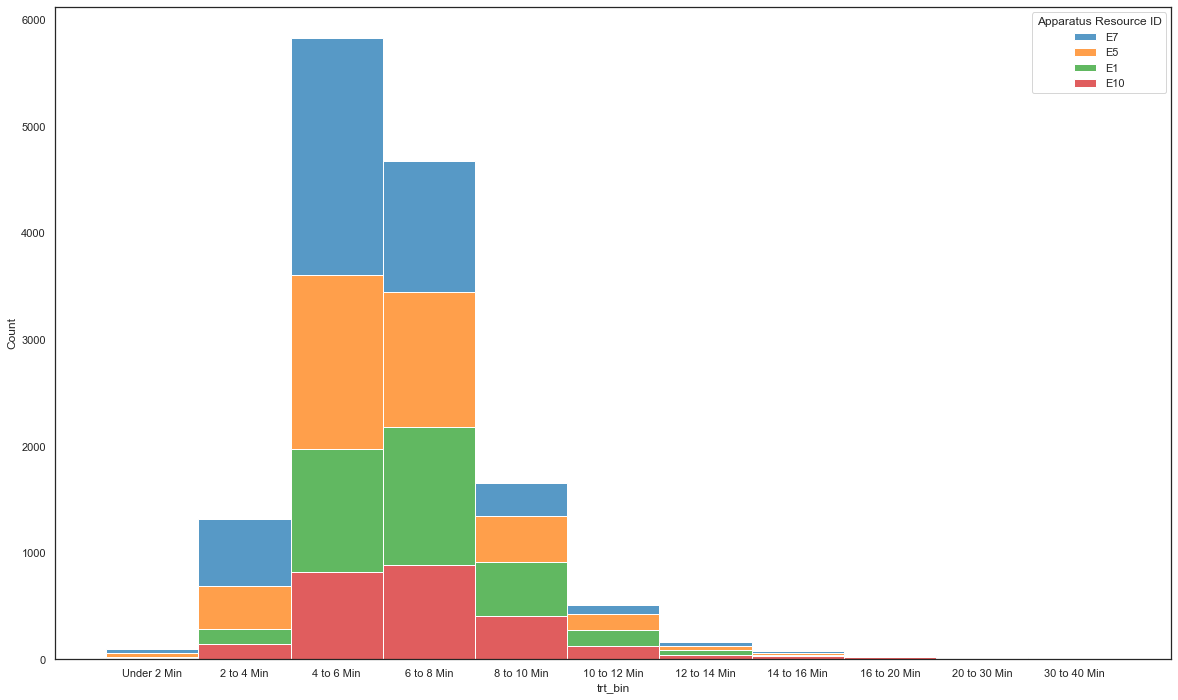

In [41]:
#plot histogram of the respone time bins
plt.figure(figsize=(20,12))
sns.histplot(data=df_engine, x="trt_bin", hue = 'Apparatus Resource ID', multiple = 'stack') 

lets also get rid of the extreme outliers to make the data a little easier to work with.  we'll drop anyting with a resonse greater than 14 min (its just under 3 standard deviations of the mean)


In [42]:
df_engine = df_engine[df_engine['Total Response Time'] < 14].copy()

lets also try cutting the data into "big" and "little" emergencies.  We'll do a 0/1 to see if there is a difference in response time (aka basement floor number in the radon example)

In [43]:
df[['Basic Incident Type Category']].value_counts()

Basic Incident Type Category                           
3 - Rescue & Emergency Medical Service Incident            60123
7 - False Alarm & False Call                               19060
6 - Good Intent Call                                        8700
4 - Hazardous Condition (No Fire)                           8350
1 - Fire                                                    6166
5 - Service Call                                            4950
2 - Overpressure Rupture, Explosion, Overheat (No Fire)      199
8 - Severe Weather & Natural Disaster                        104
9 - Special Incident Type                                     48
dtype: int64

In [44]:
# set an index for each engine
def em_level(x):
    if x == '3 - Rescue & Emergency Medical Service Incident':
        return '0'
    elif x == '7 - False Alarm & False Call':
        return '1'
    elif x == '6 - Good Intent Call ':
        return '0'
    elif x == '4 - Hazardous Condition (No Fire)':
        return '0'
    elif x == '1 - Fire':
        return '0'
    elif x == '5 - Service Call':
        return '1'
    elif x == '2 - Overpressure Rupture, Explosion, Overheat (No Fire)':
        return '0'
    elif x == '8 - Severe Weather & Natural Disaster':
        return '1'
    elif x == '9 - Special Incident Type':
        return '1'
    return

In [45]:
df_engine['em_level'] = df_engine['Basic Incident Type Category'].apply(em_level)

In [46]:
df_engine['em_level']

3        1
6        0
9        0
12       0
15       0
        ..
59777    1
59783    0
59786    1
59789    1
59792    0
Name: em_level, Length: 14248, dtype: object

In [47]:
df_engine['em_level'].value_counts()

0    10276
1     3062
Name: em_level, dtype: int64

Prof. Henry had to help with this step... set dummies variables based on our indicator

In [48]:
df_engine['em_level'].str.get_dummies()['1'].to_frame()

1
3      1
6      0
9      0
12     0
15     0
...   ..
59777  1
59783  0
59786  1
59789  1
59792  0

[14248 rows x 1 columns]

In [49]:
df_engine['em_level_dum'] = df_engine['em_level'].str.get_dummies()['1'].to_frame()

In [50]:
df_engine

Incident Number Incident Date  Basic Incident Hour Of Day 24  \
3       2017-00000020    2017-01-01                             12   
6       2017-00000021    2017-01-01                             13   
9       2017-00000025    2017-01-01                             14   
12      2017-00000027    2017-01-01                             16   
15      2017-00000046    2017-01-02                              5   
...               ...           ...                            ...   
59777   2021-00005074    2021-06-23                              6   
59783   2021-00005082    2021-06-23                             16   
59786   2021-00005107    2021-06-24                             10   
59789   2021-00005109    2021-06-24                             12   
59792   2021-00005120    2021-06-24                             18   

                Incident Primary Action Taken  \
3                              Forcible entry   
6            Provide basic life support (BLS)   
9                            Provide manpower   
12     Provide first aid & check for injuries   
15                           Provide manpower   
...                                       ...   
59777                             Investigate   
59783                             Investigate   
59786                             Investigate   
59789                             Investigate   
59792     Provide advanced life support (ALS)   

      Apparatus Resource Actions Taken Code And Description 1  \
3                                                    NaN        
6                                                    NaN        
9                                                    NaN        
12                                                   NaN        
15                                                   NaN        
...                                                  ...        
59777                                                NaN        
59783                               78 - Control traffic        
59786                                                NaN        
59789                                                NaN        
59792                                                NaN        

      Apparatus Resource Arrival Date Time  \
3                      2017-01-01 12:32:06   
6                      2017-01-01 13:19:56   
9                      2017-01-01 14:54:48   
12                     2017-01-01 16:04:43   
15                     2017-01-02 05:57:23   
...                                    ...   
59777                  2021-06-23 06:21:07   
59783                  2021-06-23 16:50:58   
59786                  2021-06-24 10:14:39   
59789                  2021-06-24 12:29:30   
59792                  2021-06-24 18:31:14   

       Apparatus Resource Arrival Sequence Number By Overall Incident  \
3                                                      1                
6                                                      1                
9                                                      1                
12                                                     1                
15                                                     1                
...                                                  ...                
59777                                                  1                
59783                                                  1                
59786                                                  1                
59789                                                  1                
59792                                                  1                

       Apparatus Resource On Scene Time in Minutes  \
3                                              NaN   
6                                              NaN   
9                                              NaN   
12                                             NaN   
15                                             NaN   
...                                      

lets save our work...

In [72]:
df_engine.to_csv('NFIRS.csv')

In [4]:
df_engine = pd.read_csv('NFIRS.csv')

In [73]:
# del(df)

now lets look at our response time (after clipping the outliers)

<AxesSubplot:xlabel='Apparatus Resource ID', ylabel='Total Response Time'>

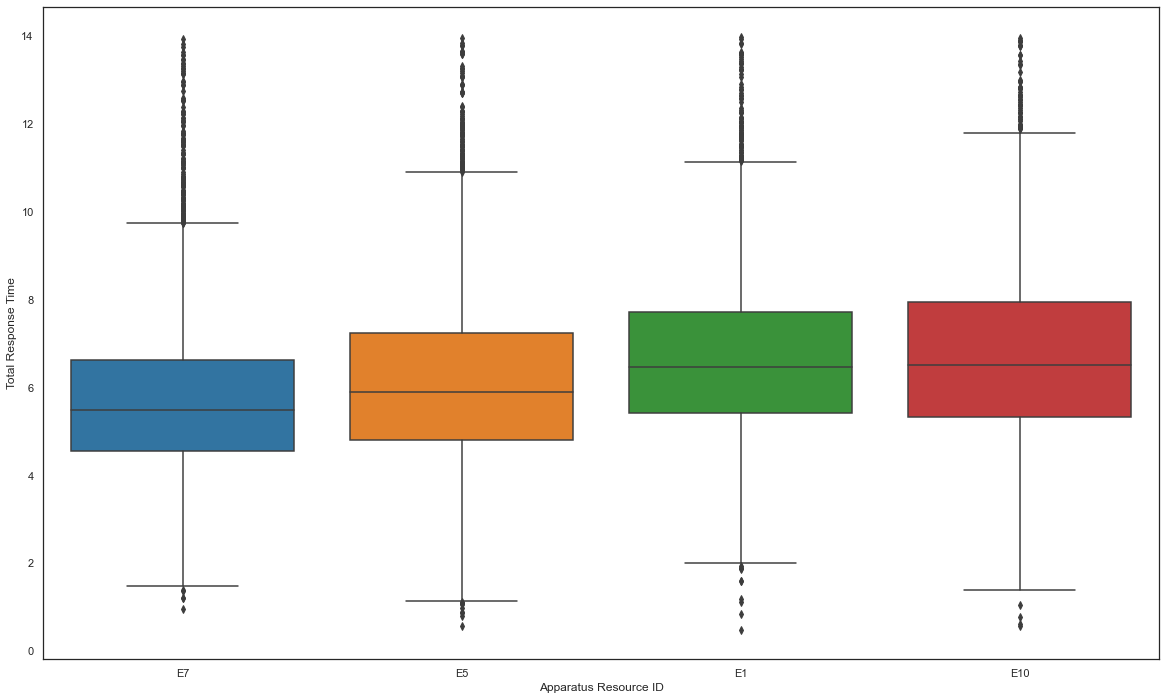

In [5]:
plt.figure(figsize=(20,12))
sns.boxplot(x=df_engine['Apparatus Resource ID'], y = df_engine['Total Response Time'])

<AxesSubplot:xlabel='Apparatus Resource ID', ylabel='Total Response Time'>

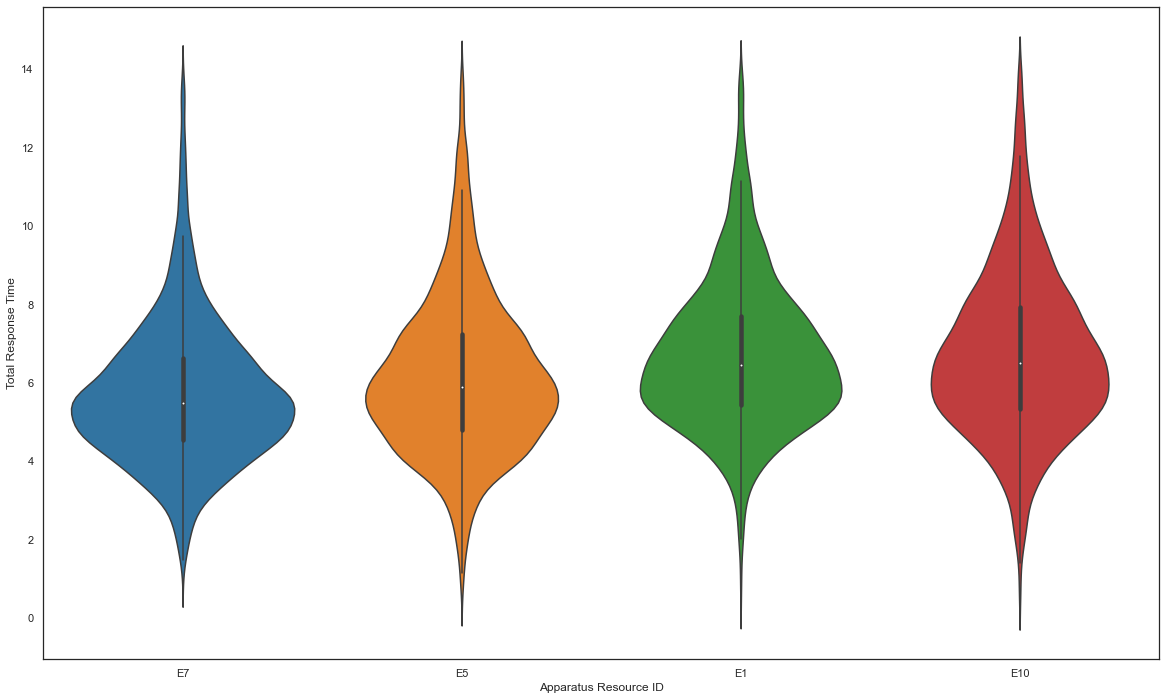

In [6]:
plt.figure(figsize=(20,12))
sns.violinplot(x=df_engine['Apparatus Resource ID'], y = df_engine['Total Response Time'])

<AxesSubplot:xlabel='Incident Date', ylabel='Total Response Time'>

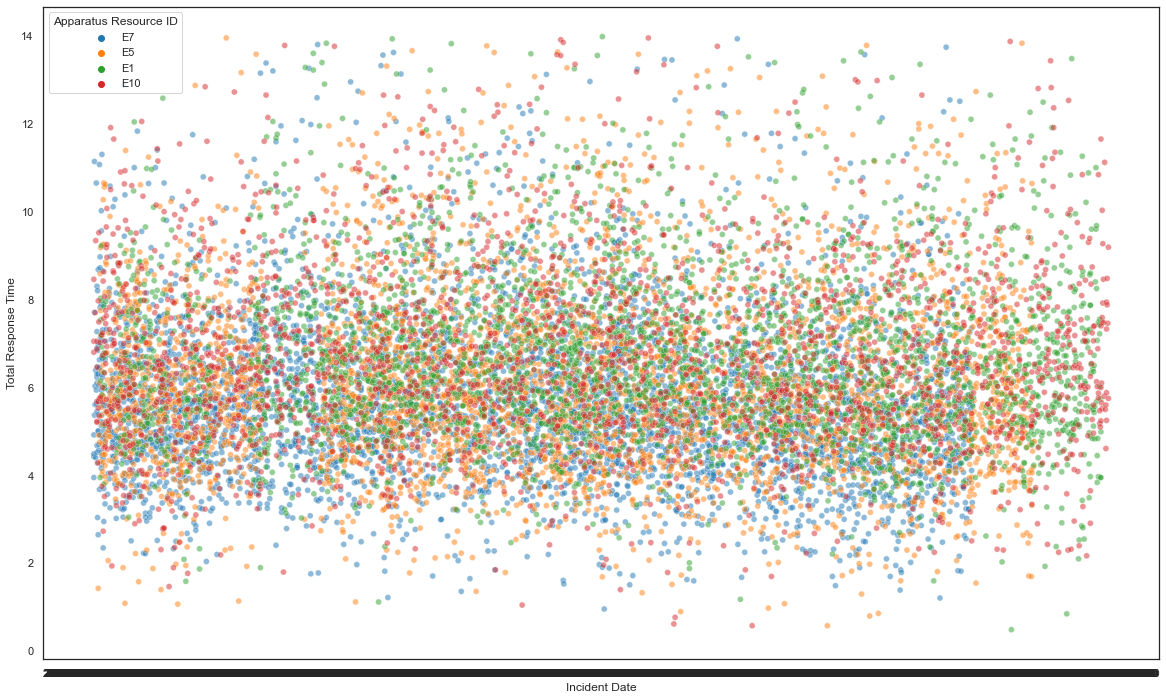

In [7]:
plt.figure(figsize=(20,12))
sns.scatterplot(x=df_engine['Incident Date'], y = df_engine['Total Response Time'], hue =df_engine['Apparatus Resource ID'], alpha = 0.5 )

features of interest 

* 'Incident Alarm Handling Time In Minutes',
* 'Apparatus Resource Turnout Time In Minutes',
* 'Apparatus Resource En Route To Arrived In Minutes',

to predict 

'Total Response Time'

<AxesSubplot:xlabel='Apparatus Resource ID', ylabel='Incident Alarm Handling Time In Minutes'>

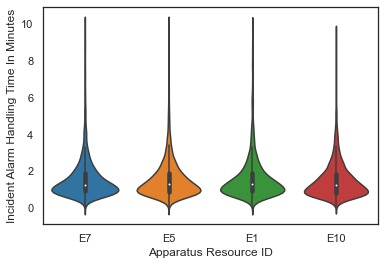

In [8]:
sns.violinplot(x=df_engine['Apparatus Resource ID'], y = df_engine['Incident Alarm Handling Time In Minutes'])

<AxesSubplot:xlabel='Apparatus Resource ID', ylabel='Apparatus Resource Turnout Time In Minutes'>

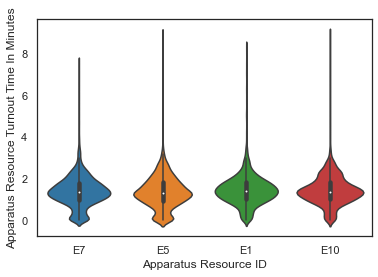

In [9]:
sns.violinplot(x=df_engine['Apparatus Resource ID'], y = df_engine['Apparatus Resource Turnout Time In Minutes'])

<AxesSubplot:xlabel='Apparatus Resource ID', ylabel='Apparatus Resource En Route To Arrived In Minutes'>

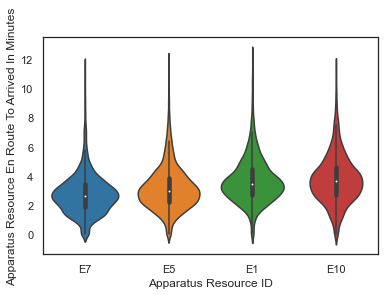

In [10]:
sns.violinplot(x=df_engine['Apparatus Resource ID'], y = df_engine['Apparatus Resource En Route To Arrived In Minutes'])

Set variables for use in PYMC3 Models

In [11]:
apparatus = df_engine['engine_index']
apparatus

0        0
1        0
2        0
3        0
4        0
        ..
14243    3
14244    3
14245    3
14246    3
14247    3
Name: engine_index, Length: 14248, dtype: int64

In [12]:
num_apparatus = len(apparatus.unique())
num_apparatus

4

In [13]:
#didn't end up using these

# alarm_mu = df_feat_ind['Incident Alarm Handling Time In Minutes'].mean()
# alarm_std = df_feat_ind['Incident Alarm Handling Time In Minutes'].std()
# alarm_std

In [14]:
# turnout_mu = df_feat_ind['Apparatus Resource Turnout Time In Minutes'].mean()
# turnout_std = df_feat_ind['Apparatus Resource Turnout Time In Minutes'].std()


In [15]:
# enroute_mu = df_feat_ind['Apparatus Resource En Route To Arrived In Minutes'].mean()
# enroute_std = df_feat_ind['Apparatus Resource En Route To Arrived In Minutes'].std()

In [16]:
# enroute_std*1.5

In [17]:
# alarm = df_engine['Incident Alarm Handling Time In Minutes']

# alarm

In [18]:
turnout = df_engine['Apparatus Resource Turnout Time In Minutes']
turnout_log = np.log(turnout)

turnout_log

0        0.336472
1        0.285179
2        0.239017
3        0.029559
4        0.512824
           ...   
14243    0.392042
14244   -1.049822
14245    0.285179
14246    0.239017
14247   -0.051293
Name: Apparatus Resource Turnout Time In Minutes, Length: 14248, dtype: float64

In [19]:
enroute = df_engine['Apparatus Resource En Route To Arrived In Minutes']
enroute_log = np.log(enroute)

enroute_log

0        0.157004
1        0.457425
2        0.841567
3        0.845868
4        0.974560
           ...   
14243    1.202972
14244    1.289233
14245    1.193922
14246    1.022451
14247   -0.127833
Name: Apparatus Resource En Route To Arrived In Minutes, Length: 14248, dtype: float64

In [20]:
# response_time = df_engine['Total Response Time']

# response_time

In [21]:
emergency_level = df_engine['em_level_dum']
# emergency_level.astype('int')
emergency_level

0        1
1        0
2        0
3        0
4        0
        ..
14243    1
14244    0
14245    1
14246    1
14247    0
Name: em_level_dum, Length: 14248, dtype: int64

In [22]:
# df_engine['em_level']

# Model 1, Total time from turnout time with log times

In [23]:
# this is the model that Prof. Henry helped with in our meeting

with pm.Model() as hierarchical_model:
    
    # Thanks to Prof. Henry's OH
    # Priors for the fixed effects
    
    #b - overall effect for Apparatus Resource Turnout Time In Minutes
    mu_b = pm.Normal('mu_b', mu=0, sd=3) #same as above, for same reasons mu=turnout_mu, sd=turnout_std
    sigma_b = pm.HalfCauchy('sigma_b', 1) #was 5, same as above, for same reasons 
    
        
    # Random intercepts as offsets 
    
    # from turnout time
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=num_apparatus)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)
    
    #linear model
    
    y_hat =  b[apparatus]*turnout_log 
    
    # Residual Error - we are doing a regression, there will be an error.
    sigma_y = pm.HalfCauchy('sigma_y', 1) # 3 standard deviation as above.

    # Data likelihood
    # our final distribution to put a tolerance on the regression results
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=enroute_log)

In [24]:
with hierarchical_model:
    hierarchical_trace = pm.sample(500, n_init=50000, tune=500) #standard values from exemplar code (1000, n_init=50000, tune=1000)

<ipython-input-24-00b2584febb6>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  hierarchical_trace = pm.sample(500, n_init=50000, tune=500) #standard values from exemplar code (1000, n_init=50000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b_offset, sigma_b, mu_b]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
There were 177 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.32616933417154365, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\Users\edwar\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'b_offset'}>,
        <AxesSubplot:title={'center':'b_offset'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma_y'}>,
        <AxesSubplot:title={'center':'sigma_y'}>]], dtype=object)

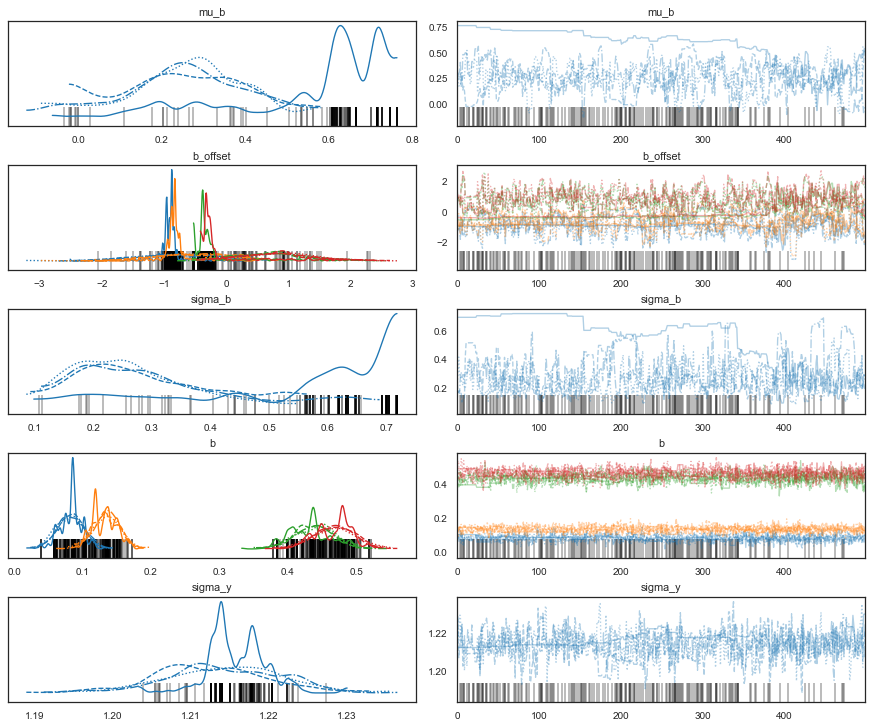

In [25]:
pm.plot_trace(hierarchical_trace)

In [26]:
summary = pm.summary(hierarchical_trace)
summary

C:\Users\edwar\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_b         0.333  0.207  -0.023    0.718      0.077    0.065       9.0   
b_offset[0] -0.809  0.585  -1.861    0.320      0.046    0.033     159.0   
b_offset[1] -0.614  0.554  -1.561    0.453      0.048    0.034     139.0   
b_offset[2]  0.516  0.672  -0.527    1.631      0.191    0.139      11.0   
b_offset[3]  0.625  0.688  -0.419    1.755      0.203    0.147      10.0   
sigma_b      0.345  0.178   0.145    0.718      0.066    0.053      10.0   
b[0]         0.082  0.019   0.047    0.118      0.001    0.000     902.0   
b[1]         0.134  0.019   0.097    0.167      0.001    0.000    1153.0   
b[2]         0.437  0.029   0.384    0.494      0.001    0.001     516.0   
b[3]         0.468  0.029   0.412    0.520      0.001    0.001    1121.0   
sigma_y      1.214  0.007   1.202    1.227      0.000    0.000     238.0   

             ess_tail  r_hat  
mu_b             16.0   1.41  
b_offset[0]     110.0   1.25  
b_offset[1]     193.0   1.11  
b_offset[2]      31.0   1.28  
b_offset[3]      24.0   1.33  
sigma_b          15.0   1.33  
b[0]            968.0   1.02  
b[1]           1303.0   1.00  
b[2]            425.0   1.01  
b[3]           1225.0   1.01  
sigma_y         519.0   1.08

# Model 2, same as model 1 but using regular (non log) time

In [27]:
# this is the model is the same model that doesn't use logs

with pm.Model() as hierarchical_model:
    
    #b - overall effect for Apparatus Resource Turnout Time In Minutes
    mu_b = pm.Normal('mu_b', mu=0, sd=3) #same as above, for same reasons mu=turnout_mu, sd=turnout_std
    sigma_b = pm.HalfCauchy('sigma_b', 1) #was 5, same as above, for same reasons 
    
    # Random intercepts as offsets 
    
    # from turnout time
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=num_apparatus)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)
    
    # model
    y_hat =  b[apparatus]*turnout 
    
    # Residual Error - we are doing a regression, there will be an error.
    sigma_y = pm.HalfCauchy('sigma_y', 1) # 3 standard deviation as above.

    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=enroute)

In [28]:
with hierarchical_model:
    hierarchical_trace = pm.sample(500, n_init=50000, tune=500) #standard values from exemplar code (1000, n_init=50000, tune=1000)

<ipython-input-28-00b2584febb6>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  hierarchical_trace = pm.sample(500, n_init=50000, tune=500) #standard values from exemplar code (1000, n_init=50000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b_offset, sigma_b, mu_b]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 31 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\Users\edwar\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'b_offset'}>,
        <AxesSubplot:title={'center':'b_offset'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma_y'}>,
        <AxesSubplot:title={'center':'sigma_y'}>]], dtype=object)

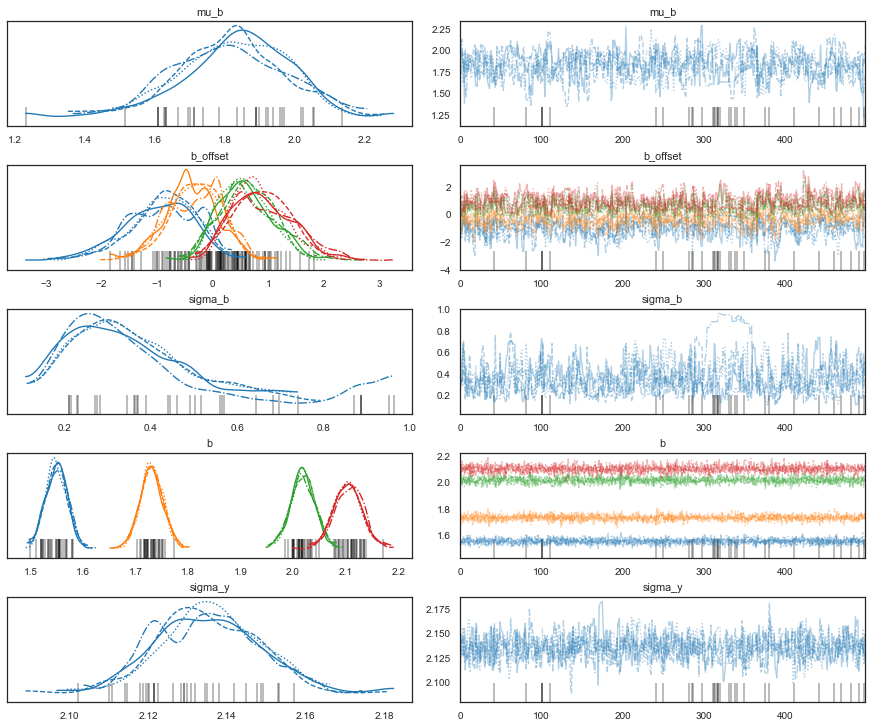

In [29]:
pm.plot_trace(hierarchical_trace)

In [30]:
summary = pm.summary(hierarchical_trace)
summary

C:\Users\edwar\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_b         1.825  0.152   1.554    2.107      0.008    0.006     383.0   
b_offset[0] -0.929  0.618  -2.104    0.104      0.031    0.022     381.0   
b_offset[1] -0.335  0.482  -1.258    0.503      0.022    0.016     466.0   
b_offset[2]  0.610  0.485  -0.230    1.494      0.022    0.015     507.0   
b_offset[3]  0.890  0.537  -0.043    1.860      0.025    0.017     480.0   
sigma_b      0.363  0.162   0.120    0.667      0.016    0.014     188.0   
b[0]         1.550  0.020   1.514    1.588      0.000    0.000    1782.0   
b[1]         1.731  0.021   1.689    1.770      0.000    0.000    2048.0   
b[2]         2.019  0.023   1.977    2.064      0.001    0.000    1976.0   
b[3]         2.105  0.027   2.053    2.154      0.001    0.000    1744.0   
sigma_y      2.135  0.013   2.113    2.159      0.001    0.000     621.0   

             ess_tail  r_hat  
mu_b            503.0   1.01  
b_offset[0]     656.0   1.01  
b_offset[1]     683.0   1.01  
b_offset[2]     560.0   1.01  
b_offset[3]     555.0   1.01  
sigma_b          68.0   1.02  
b[0]           1644.0   1.00  
b[1]           1428.0   1.00  
b[2]           1637.0   1.00  
b[3]           1290.0   1.00  
sigma_y         784.0   1.00

# Model 3, same as Model 2 but adding an "emergency level effect"

In [31]:
# this is the model is the same model second model but trying to do "floor effect" using emergency type

with pm.Model() as hierarchical_model:
    
    #b - overall effect for Apparatus Resource Turnout Time In Minutes
    mu_b = pm.Normal('mu_b', mu=0, sd=3) #same as above, for same reasons 
    sigma_b = pm.HalfCauchy('sigma_b', 1) #was 5, same as above, for same reasons 
    
    #em - overall effect of adding emergency level
    mu_em = pm.Normal('mu_em', mu=0., sd=3) #same as above, for same reasons
    sigma_em = pm.HalfCauchy('sigma_em', 1) #was 5, same as above, for same reasons 

    # Random intercepts as offsets 
    # from turnout time
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=num_apparatus)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)
    
    # from the emergency level
    em_offset = pm.Normal('em_offset', mu=0, sd=1, shape=num_apparatus)
    em = pm.Deterministic("em", mu_em + em_offset * sigma_em)

    y_hat =  b[apparatus]*turnout + em[apparatus]*emergency_level

    # Residual Error - we are doing a regression, there will be an error.
    sigma_y = pm.HalfCauchy('sigma_y', 1) # 3 standard deviation as above.

    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=enroute)

In [32]:
with hierarchical_model:
    hierarchical_trace = pm.sample(500, n_init=50000, tune=500) #standard values from exemplar code (1000, n_init=50000, tune=1000)

<ipython-input-32-00b2584febb6>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  hierarchical_trace = pm.sample(500, n_init=50000, tune=500) #standard values from exemplar code (1000, n_init=50000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, em_offset, b_offset, sigma_em, mu_em, sigma_b, mu_b]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 55 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


C:\Users\edwar\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'mu_em'}>,
        <AxesSubplot:title={'center':'mu_em'}>],
       [<AxesSubplot:title={'center':'b_offset'}>,
        <AxesSubplot:title={'center':'b_offset'}>],
       [<AxesSubplot:title={'center':'em_offset'}>,
        <AxesSubplot:title={'center':'em_offset'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'sigma_em'}>,
        <AxesSubplot:title={'center':'sigma_em'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'em'}>,
        <AxesSubplot:title={'center':'em'}>],
       [<AxesSubplot:title={'center':'sigma_y'}>,
        <AxesSubplot:title={'center':'sigma_y'}>]], dtype=object)

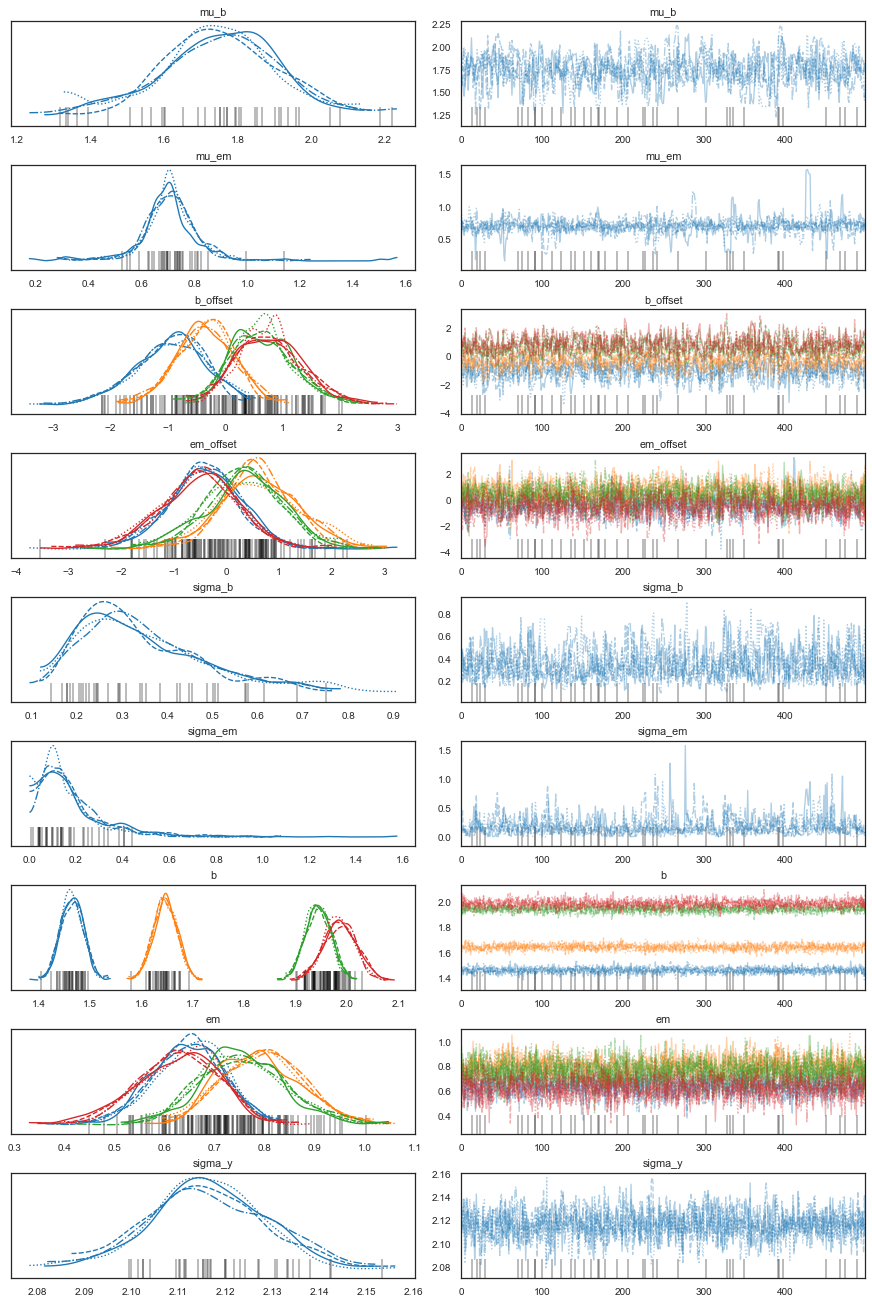

In [33]:
pm.plot_trace(hierarchical_trace)

In [34]:
summary = pm.summary(hierarchical_trace)
summary

C:\Users\edwar\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_b          1.749  0.162   1.426    2.074      0.008    0.005     478.0   
mu_em         0.707  0.115   0.505    0.914      0.005    0.004     736.0   
b_offset[0]  -0.957  0.613  -2.068    0.237      0.025    0.018     587.0   
b_offset[1]  -0.351  0.500  -1.369    0.513      0.021    0.015     580.0   
b_offset[2]   0.643  0.542  -0.392    1.627      0.022    0.015     621.0   
b_offset[3]   0.784  0.570  -0.271    1.840      0.022    0.016     642.0   
em_offset[0] -0.420  0.701  -1.710    0.901      0.022    0.017     995.0   
em_offset[1]  0.618  0.740  -0.644    2.157      0.024    0.018     943.0   
em_offset[2]  0.325  0.726  -1.095    1.625      0.022    0.019    1086.0   
em_offset[3] -0.528  0.753  -1.926    0.898      0.024    0.017     945.0   
sigma_b       0.348  0.141   0.148    0.647      0.006    0.004     566.0   
sigma_em      0.173  0.150   0.000    0.427      0.007    0.005     427.0   
b[0]          1.465  0.022   1.422    1.503      0.001    0.000    1910.0   
b[1]          1.646  0.023   1.601    1.687      0.001    0.000    1626.0   
b[2]          1.943  0.024   1.897    1.987      0.001    0.000    1849.0   
b[3]          1.986  0.031   1.925    2.042      0.001    0.001    1788.0   
em[0]         0.648  0.071   0.523    0.790      0.002    0.001    1695.0   
em[1]         0.795  0.079   0.649    0.939      0.002    0.002    1134.0   
em[2]         0.757  0.086   0.602    0.924      0.002    0.002    1628.0   
em[3]         0.629  0.081   0.479    0.771      0.002    0.002    1322.0   
sigma_y       2.116  0.012   2.094    2.140      0.000    0.000    1476.0   

              ess_tail  r_hat  
mu_b             476.0   1.00  
mu_em            588.0   1.01  
b_offset[0]      499.0   1.00  
b_offset[1]      744.0   1.00  
b_offset[2]      593.0   1.00  
b_offset[3]      572.0   1.00  
em_offset[0]    1020.0   1.00  
em_offset[1]     786.0   1.01  
em_offset[2]    1060.0   1.00  
em_offset[3]    1178.0   1.00  
sigma_b          548.0   1.00  
sigma_em         475.0   1.01  
b[0]            1651.0   1.00  
b[1]            1711.0   1.00  
b[2]            1499.0   1.00  
b[3]            1433.0   1.00  
em[0]           1748.0   1.00  
em[1]           1403.0   1.00  
em[2]           1670.0   1.00  
em[3]           1553.0   1.00  
sigma_y         1291.0   1.01

# Model 4, same as model 3 but using log times

In [35]:
# this is the model is the same model second model but trying to do "floor effect" using emergency type and log values

with pm.Model() as hierarchical_model:
    
    #b - overall effect for Apparatus Resource Turnout Time In Minutes
    mu_b = pm.Normal('mu_b', mu=0, sd=3) #same as above, for same reasons mu=turnout_mu, sd=turnout_std
    sigma_b = pm.HalfCauchy('sigma_b', 1) #was 5, same as above, for same reasons 
    
    #em - overall effect of adding emergency level
    mu_em = pm.Normal('mu_em', mu=0., sd=3) #same as above, for same reasons
    sigma_em = pm.HalfCauchy('sigma_em', 1) #was 5, same as above, for same reasons 
    
    # Random intercepts as offsets 
    # from turnout time
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=num_apparatus)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)
    
    # from the emergency level
    em_offset = pm.Normal('em_offset', mu=0, sd=1, shape=num_apparatus)
    em = pm.Deterministic("em", mu_em + em_offset * sigma_em)

    # model
    y_hat =  b[apparatus]*turnout_log + em[apparatus]*emergency_level

    # Residual Error - we are doing a regression, there will be an error.
    sigma_y = pm.HalfCauchy('sigma_y', 1) # 3 standard deviation as above.

    # Data likelihood
    # our final distribution to put a tolerance on the regression results
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=enroute_log)

In [36]:
with hierarchical_model:
    hierarchical_trace = pm.sample(500, n_init=50000, tune=500) #standard values from exemplar code (1000, n_init=50000, tune=1000)

<ipython-input-36-00b2584febb6>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  hierarchical_trace = pm.sample(500, n_init=50000, tune=500) #standard values from exemplar code (1000, n_init=50000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, em_offset, b_offset, sigma_em, mu_em, sigma_b, mu_b]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7079711531269952, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\Users\edwar\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'mu_em'}>,
        <AxesSubplot:title={'center':'mu_em'}>],
       [<AxesSubplot:title={'center':'b_offset'}>,
        <AxesSubplot:title={'center':'b_offset'}>],
       [<AxesSubplot:title={'center':'em_offset'}>,
        <AxesSubplot:title={'center':'em_offset'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'sigma_em'}>,
        <AxesSubplot:title={'center':'sigma_em'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'em'}>,
        <AxesSubplot:title={'center':'em'}>],
       [<AxesSubplot:title={'center':'sigma_y'}>,
        <AxesSubplot:title={'center':'sigma_y'}>]], dtype=object)

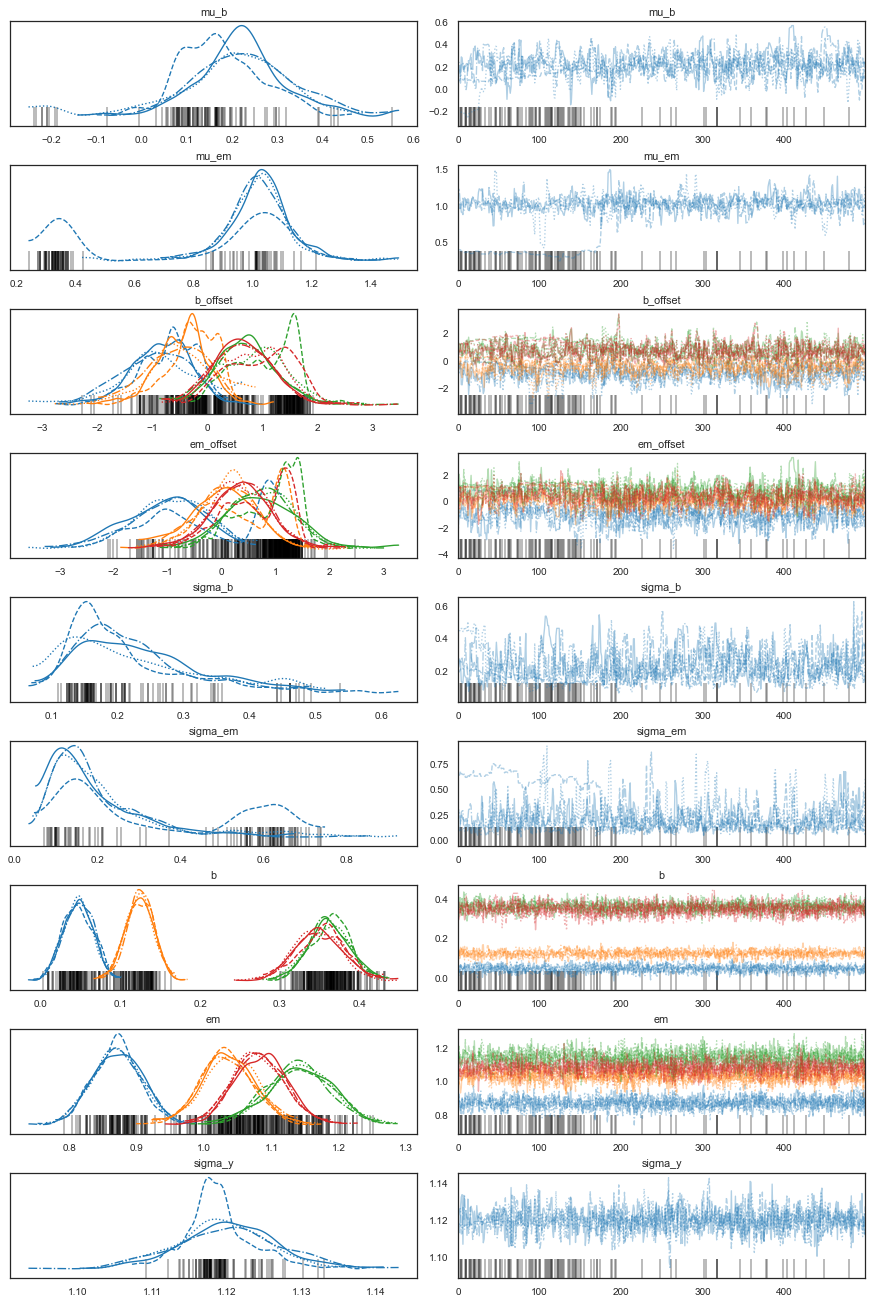

In [37]:
pm.plot_trace(hierarchical_trace)

In [38]:
summary = pm.summary(hierarchical_trace)
summary

C:\Users\edwar\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_b          0.204  0.116   0.020    0.454      0.010    0.007     135.0   
mu_em         0.964  0.220   0.323    1.205      0.081    0.059      19.0   
b_offset[0]  -0.844  0.622  -2.108    0.201      0.045    0.032     182.0   
b_offset[1]  -0.440  0.543  -1.483    0.576      0.043    0.030     152.0   
b_offset[2]   0.815  0.592  -0.282    1.764      0.089    0.064      45.0   
b_offset[3]   0.751  0.577  -0.207    1.818      0.092    0.066      39.0   
em_offset[0] -0.843  0.852  -2.139    1.008      0.222    0.160      19.0   
em_offset[1]  0.151  0.626  -0.969    1.278      0.123    0.092      28.0   
em_offset[2]  0.781  0.631  -0.438    1.784      0.045    0.032     151.0   
em_offset[3]  0.424  0.591  -0.603    1.492      0.092    0.075      42.0   
sigma_b       0.224  0.096   0.071    0.413      0.007    0.005     204.0   
sigma_em      0.236  0.168   0.060    0.628      0.049    0.037      22.0   
b[0]          0.047  0.019   0.012    0.080      0.001    0.000    1163.0   
b[1]          0.124  0.018   0.091    0.156      0.000    0.000    1445.0   
b[2]          0.362  0.025   0.316    0.412      0.001    0.000    1618.0   
b[3]          0.350  0.030   0.291    0.402      0.001    0.001     688.0   
em[0]         0.871  0.036   0.804    0.937      0.001    0.001    1845.0   
em[1]         1.035  0.040   0.960    1.110      0.001    0.001    1725.0   
em[2]         1.142  0.047   1.055    1.230      0.001    0.001    1677.0   
em[3]         1.081  0.039   1.012    1.156      0.001    0.001    1630.0   
sigma_y       1.120  0.006   1.108    1.132      0.000    0.000    1425.0   

              ess_tail  r_hat  
mu_b             135.0   1.04  
mu_em             13.0   1.16  
b_offset[0]      162.0   1.02  
b_offset[1]      201.0   1.03  
b_offset[2]      479.0   1.07  
b_offset[3]      164.0   1.07  
em_offset[0]      17.0   1.16  
em_offset[1]      58.0   1.10  
em_offset[2]     975.0   1.03  
em_offset[3]     760.0   1.07  
sigma_b          180.0   1.02  
sigma_em          26.0   1.12  
b[0]            1278.0   1.00  
b[1]            1493.0   1.00  
b[2]            1636.0   1.00  
b[3]            1061.0   1.01  
em[0]           1730.0   1.00  
em[1]           1372.0   1.00  
em[2]           1354.0   1.00  
em[3]           1501.0   1.00  
sigma_y          816.0   1.04